In [ ]:
from jupyter_client import find_connection_file
connection_file = find_connection_file()
print(connection_file)

In [ ]:
#Plotting related
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
pio.renderers.default='notebook'

# Scikit-learn related imports
import pyarrow
import pandas as pd
pd.options.mode.copy_on_write = True
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import randint, ttest_ind
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_decision_regions

In [ ]:
dataset_col = "Dataset"
uid_col = "uid"
age_col = "Age"
day_col = "Day"
response_col = "Response"
immage_col = "IMMAGE"
strain_col = 'Strain'

In [ ]:
def get_data_dir():
   # Define the starting directory
   current_dir = os.getcwd()

   # Traverse up the directory tree until we find a directory named "data"
   while current_dir != "/":
      if "data" in os.listdir(current_dir):
         data_dir = os.path.join(current_dir, "data")
         return data_dir
      current_dir = os.path.dirname(current_dir)
   else:
      print("Directory 'data' not found in the parent directories.")
      raise()



In [ ]:
# Read in Data and drop missing values
data_dir = get_data_dir()
df = pd.read_csv(os.path.join(data_dir, "../data/all_vaccines.csv"))
df.dropna(inplace=True, subset=[immage_col, dataset_col, day_col, response_col])

dataset_names = df.Dataset.unique()

##### Plot distribution of studies' N values

In [ ]:
# Plot distribution of N values
N_vals = df[[dataset_col, uid_col]].groupby(dataset_col, as_index=False)[uid_col].nunique()
N_vals = N_vals.rename(columns={uid_col: "N"})
sns.histplot(N_vals.N)
plt.title("N values across studies")

##### Narrow to large datasets only (N > 70)

In [ ]:
# Narrow N_v to large datasets only
N_vals = N_vals.loc[N_vals["N"] > 70]
datasets = df.loc[df["Dataset"].isin(N_vals["Dataset"])]
dataset_names = datasets["Dataset"].unique()
N_vals

In [ ]:
# Examine available days per dataset
days = datasets[[dataset_col, uid_col, day_col]].groupby(dataset_col, as_index=False)[day_col].unique()
t = pd.Series(days.loc[[True, False, False, False], "Day"])
# with pd.option_context('display.max_colwidth', None):
#    for index, row in days.iterrows():
#     print(f"Dataset: {row['Dataset']}\nDays: {row['Day']}\n\n")

In [ ]:
# Collect day info from papers here
dataset_day_dict = {}

dataset_day_dict["GSE41080.SDY212"] = "HAI.D28"
dataset_day_dict["GSE48018.SDY1276"] = "nAb.D28"
dataset_day_dict["GSE48023.SDY1276"] = "nAb.D28"
dataset_day_dict["SDY67"] = "nAb.D28"
# dataset_day_dict[dataset_names[0]]

##### Narrow to a specific dataset and day, then keep only relevant columns

In [ ]:
# Narrow to a specific dataset and day, then keep only relevant columns
strain_index = 0
dataset_name = dataset_names[0]

In [ ]:
name_mask = datasets[dataset_col] == dataset_name
day_mask = datasets[day_col] == dataset_day_dict[dataset_name]

data = datasets.loc[(name_mask) & (day_mask)].reset_index()

# Somtimes there are multiple strains - so multiple rows per day
strains = data[strain_col].unique()
if len(strains) > 1:
   data = data.loc[data[strain_col] == strains[strain_index]].reset_index()

strains_t = data[strain_col].unique()
assert(len(strains_t) == 1)
strain = strains_t[0]

# Sometimes there are multiple geo_accession numbers, like in GSE48018.SDY1276, average the IMMAGE, since all else is the same
accessions = data["geo_accession"].unique()
if len(accessions) > 1:
   print(f"*** Multiple accession detected! Collapsing by averaging on IMMAGE value ***\n")
   data =  data.groupby(uid_col, as_index=False).agg({immage_col: 'mean', **{col: 'first' for col in data.columns if col not in [uid_col, immage_col]}})

# Take relevant columns only
data = data[[immage_col, response_col, age_col]]

print(f"Working with dataset {dataset_name}")
print(f"Working with strain {strain}")
print(f"Total subjects in study: N={data.shape[0]}")
print(f"available strains: {strains}")

# data.head()

In [ ]:
# Get a boolean map of sub and super threshold values
low_response_thr = data[[response_col]].quantile(q=0.3).item()

# Generate labels
# Note that we define y=1 for all responses < 30th percentile (and not <=)
# Also note that we defined y=1 as *non* responders, since later on that's what we'll care most about detecting

data['y'] = data[response_col].apply(lambda x: 1 if x < low_response_thr else 0)

# Add a text label for plot legends
data['Label text'] = data['y'].apply(lambda x: 'Responders' if x == 0 else 'Non-Responders')

##### Plot IMMAGE, response, and age values to look at the dynamic range

In [ ]:
# Plot IMMAGE, response, and age values to look at the dynamic range
from scipy.stats import probplot
fig, axs = plt.subplots(2, 3, figsize=(18, 6))  # Create a figure with two subplots side by side

sns.histplot(data=data, x=immage_col, bins=50, ax=axs[0, 0])
sns.boxplot(data=data, x=immage_col, ax=axs[1, 0], fill=False)
# axs[0].set_title('Box Plot')
axs[0, 0].set_title(f' {immage_col}')

sns.histplot(data=data, x=response_col, bins=50, ax=axs[0, 1])
sns.boxplot(data=data, x=response_col, ax=axs[1, 1], fill=False)
# axs[1].set_title('Box Plot')
axs[0, 1].set_title(f' {response_col}')

sns.histplot(data=data, x=age_col, bins=50, ax=axs[0, 2])
sns.boxplot(data=data, x=age_col, ax=axs[1, 2], fill=False)
# axs[1].set_title('Box Plot')
axs[0, 2].set_title(f' {age_col}')

plt.tight_layout(pad=3.0)  # Adjust the layout so everything fits without overlap
fig.suptitle(f'Values Distribution in {dataset_name}, strain: {strain}')

plt.show()

##### Is there a trend like we expect? (High IMMAGE ⇒ low response)
#### Also show the distributions of IMMAGE values for responders & non-responders

In [ ]:
def plot_trend(data, column):
   # Sort the data by "IMMAGE" column
   sorted_data = data.sort_values(by=column)

   # Create a figure and a grid of subplots (1 row, 2 columns)
   fig, axes = plt.subplots(1, 2, figsize=(12, 5))

   # Plot the scatterplot on the first subplot
   sns.scatterplot(data=sorted_data, x=column, y="Response", hue="Label text", palette='Set1', ax=axes[0])
   axes[0].set_title(f'Vaccine response vs column\n({dataset_name}, {strain})')

   # Plot histograms on the second subplot
   sns.histplot(data=data[data["y"] == 0], x=column, ax=axes[1], color="blue", alpha=0.5, label="Responders", bins=20)
   sns.histplot(data=data[data["y"] == 1], x=column, ax=axes[1], color="orange", alpha=0.5, label="Non-responders", bins=20)
   axes[1].set_title(f"Histograms of {column} values")
   axes[1].legend()

   # Adjust layout
   plt.tight_layout()

   # Show the plots
   plt.show()

plot_trend(data, immage_col)
plot_trend(data, age_col)

In [ ]:
%%script true
# Plot the response value against sorted IMMAGE, with markers signifying labels
sorted_data = data.sort_values(by="IMMAGE")
sns.scatterplot(data=sorted_data, x="IMMAGE", y="Response", hue="Label text", palette='Set1')
plt.title(f'Vaccine response vs IMMAGE\n({dataset_name}, {strain})')
plt.show()

In [ ]:
# Running a t-test
low_group = data.loc[data[response_col]  < low_response_thr, immage_col]
high_group = data.loc[data[response_col]  >= low_response_thr, immage_col]
# print(f"low group N={low_group.shape[0]}, high group N={high_group.shape[0]}")

ttest = ttest_ind(low_group, high_group)
# print(f"pvalue: {ttest.pvalue}")

##### Classifying with logistic regression - cross validation

In [ ]:
# Classifying with logistic regression - cross validation
log_regress_immage = LogisticRegression()
log_regress_age = LogisticRegression()
regression_result = cross_validate(log_regress_immage, data[[immage_col]],  data["y"])
print(f"Mean classification accuracy (logistic regression): {regression_result['test_score'].mean()}")

##### Classifying with logistic regression - fitting the entire dataset, and checking the threshold

In [ ]:
# Classifying with logistic regression - fit on the entire dataset
from math import log

# Split the data into training and testing sets
# X_train, X_test, labels_train, labels_test = train_test_split(data[[immage_col]], data["y"],
                                                              # test_size=0.2, random_state=42)
# log_regress_immage.score(X_test, labels_test)

def get_threshold_from_probability(prob, intercept, slope):
  return -1 * (log(1/prob - 1) + intercept)/slope

# Train a classidier based on immage and on age for comparison
log_regress_immage.fit(data[[immage_col]],  data["y"])
log_regress_age.fit(data[[age_col]],  data["y"])
intercept = log_regress_immage.intercept_[0]
slope = log_regress_immage.coef_[0][0]

# Calculate the cutoff value
# print(f' intercept: {intercept}, slope: {slope}')
cutoff = get_threshold_from_probability(0.5, intercept=intercept, slope=slope) # 0.5 is the default threshold

print(f"IMMAGE cutoff value is: {cutoff}")

In [ ]:
%%script true
# Plot the logistic regression decision function
from scipy.special import expit
dft = pd.DataFrame()
dft["x"] = np.linspace(-1, 1, 500)
dft["y"] = intercept + dft.x * slope
dft["y2"] = expit(dft.x)
dft["y3"] = expit(dft.y)
sns.lineplot(data=dft, x="x", y="y2")
sns.lineplot(data=dft, x="x", y="y3")
plt.title(f'expit and expit(a*X + b)\n({dataset_name}, {strain})')
plt.show()

In [ ]:
# Plot IMMAGE values and the cutoff
sns.scatterplot(data=data.sort_values(immage_col, ignore_index=True).reset_index(), x="index", y=immage_col, hue="Label text")
# commented out since cutoff is much higher and messes with the plot
plt.axhline(y=cutoff)
plt.title(f'sorted IMMAGE vs Index\n({dataset_name}, {strain})')
plt.show()

##### Logistic regreesion preforms badly, but maybe it still assigns probabilities in a way that makes sense?

In [ ]:
non_responder_col = "p_non_responder"
non_responder_col_age = "p_non_responder_age"
proba = pd.DataFrame(log_regress_immage.predict_proba(data[[immage_col]]))
data[non_responder_col] = proba[1]

proba = pd.DataFrame(log_regress_age.predict_proba(data[[age_col]]))
data[non_responder_col_age] = proba[1]

sns.scatterplot(data=data, x=immage_col, y=non_responder_col, hue="Label text", palette='Set1')
plt.title(f'logistic regression probabilities vs {immage_col}\n({dataset_name}, {strain})')
plt.show()

sns.scatterplot(data=data, x=age_col, y=non_responder_col_age, hue="Label text", palette='Set1')
plt.title(f'logistic regression probabilities vs {age_col}\n({dataset_name}, {strain})')
plt.show()

That's a good sign that the regressor picked up on an underlying dynamic in the direction that we were expecting.

 Since this is the case, maybe an ROC curve where we shift the decision threshold based on probability will still work. (The default for log. reg. is to put the decision boundary at p=0.5)

 The focus here is to find a threshold for classifying *non-repsponders* which maximizes the proportion of non-responders in the predicted group, not caring about predicting responders for now.

##### Use a logistic regression's probabilties to look for a threshold based on above-threshold non-responder rate

In [ ]:
# Define auxilary functions
from sklearn.metrics import auc, roc_auc_score, roc_curve
from math import log
# from IPython.core.debugger import set_trace
import pdb

def calc_and_plot_prob_threshold(data, classifier, fpr, tpr, thresholds, col_name):
   roc_auc = auc(fpr, tpr)
   intercept = classifier.intercept_[0]
   slope = classifier.coef_[0][0]

   # Identifying the optimal threshold (using Youden’s Index)
   optimal_idx = np.argmax(tpr - fpr)
   prob_threshold = thresholds[optimal_idx]

   # Calculate the cutoff value
   feature_threshold = get_threshold_from_probability(prob_threshold, intercept=intercept, slope=slope)

   fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # Creates a figure with two side-by-side subplots

   # Plot ROC curve on the first subplot
   axs[0].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc : 0.2f})')
   axs[0].plot([0, 1], [0, 1], 'k--')  # Random chance line
   axs[0].plot(fpr[optimal_idx], tpr[optimal_idx], marker='o', markersize=5, color="red")
   axs[0].set_xlim([0.0, 1.0])
   axs[0].set_ylim([0.0, 1.05])
   axs[0].set_xlabel('False Positive Rate')
   axs[0].set_ylabel('True Positive Rate')
   axs[0].set_title('ROC curve')
   axs[0].legend(loc="lower right")

   # Plot sorted IMMAGE values vs Index on the second subplot
   sorted_data = data.sort_values(col_name, ignore_index=True).reset_index()
   sns.scatterplot(ax=axs[1], data=sorted_data, x="index", y=col_name, hue="Label text")
   axs[1].axhline(y=feature_threshold, color='black', linestyle='--')
   axs[1].set_title(f'Sorted {col_name} vs Index')

   fig.suptitle(f'Probability-based threshold with ROC\n({dataset_name}, {strain})')
   plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area.
   plt.show()
   return prob_threshold, feature_threshold

def get_classifier_stats_prob(data, feature_column, prob_column, prob_threshold, feature_threshold):
   # Global measures (entire dataset)
   optimal_pred = data[prob_column].apply(lambda x: 1 if x >= prob_threshold else 0)
   test_accuracy = accuracy_score(data["y"], optimal_pred)
   # Performance above the prob_threshold
   y_over_thr = data.loc[data[prob_column] >= prob_threshold, ["y"]]
   non_response_rate_over_thr = y_over_thr.mean().y
   y_under_thr = data.loc[data[prob_column] < prob_threshold, ["y"]]
   non_response_rate_under_thr = y_under_thr.mean().y
   print(f"Optimal threshold: {feature_threshold : 0.2f} ({feature_column} value), Non-responder rate: over threshold: {non_response_rate_over_thr : 0.2f}, under threshold: {non_response_rate_under_thr : 0.2f}")

In [ ]:
# Run for immage and age to compare
# IMMAGE
fpr, tpr, thresholds = roc_curve(data["y"], data[non_responder_col])
prob_threshold, feature_threshold = calc_and_plot_prob_threshold(data, log_regress_immage, fpr, tpr, thresholds, immage_col)
get_classifier_stats_prob(data, immage_col, non_responder_col, prob_threshold, feature_threshold)

# Age
fpr, tpr, thresholds = roc_curve(data["y"], data[non_responder_col_age])
prob_threshold_age, feature_threshold_age = calc_and_plot_prob_threshold(data, log_regress_age, fpr, tpr, thresholds, age_col)
get_classifier_stats_prob(data, age_col, non_responder_col_age, prob_threshold_age, feature_threshold_age)

##### An alternative is to try hard IMMAGE-based thresholds - i.e., using IMMAGE values as thresholds instead of the "soft" probabilities from the classifier :

In [ ]:
# Define auxilary functions
def calc_and_plot_hard_threshold(data, fpr, tpr, thresholds, col_name):
   # Manually create threshold values. Only take y=1 (non-responders) as thresholds.
   sorted_values = pd.DataFrame(pd.unique(data.loc[data["y"] == 1, col_name])).sort_values(by=0)
   thresholds = sorted_values[0]
   roc_points = []

   for t in thresholds:
      # Binary predictions based on the current threshold
      y_pred = (data[col_name] >= t).astype(int)

      # Calculate TPR and FPR for the current set of binary predictions.
      # When roc_curve is given a binary array instead of probabilities, it calculates the fpr and tpr for the single threshold that they represent
      fpr, tpr, _ = roc_curve(data["y"], y_pred)
      roc_points.append((fpr[1], tpr[1]))  # Assuming single threshold; fpr and tpr have two elements


   # Separate FPR and TPR values for plotting
   fprs, tprs = zip(*roc_points)
   fpr = pd.DataFrame(fprs).values
   tpr = pd.DataFrame(tprs).values

   # Identifying the optimal threshold (example using Youden’s Index)
   optimal_idx = np.argmax(tpr - fpr)
   feature_threshold = thresholds[optimal_idx]

   fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # Creates a figure with two side-by-side subplots
   roc_auc = auc(fpr, tpr)
   axs[0].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc : 0.2f})')
   axs[0].plot([0, 1], [0, 1], 'k--')  # Random chance line
   axs[0].plot(fpr[optimal_idx], tpr[optimal_idx], marker='o', markersize=5, color="red")
   axs[0].set_xlim([0.0, 1.0])
   axs[0].set_ylim([0.0, 1.05])
   axs[0].set_xlabel('False Positive Rate')
   axs[0].set_ylabel('True Positive Rate')
   axs[0].set_title('ROC curve')
   axs[0].legend(loc="lower right")

   # Plot sorted IMMAGE values vs Index on the second subplot
   sns.scatterplot(data=data.sort_values(col_name, ignore_index=True).reset_index(), x="index", y=col_name, hue="Label text")
   axs[1].axhline(y=feature_threshold, color='black', linestyle='--')
   axs[1].set_title(f'Sorted {col_name} vs Index')

   fig.suptitle(f'"Hard" {col_name}-based threshold with ROC\n({dataset_name}, {strain})')
   plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area.
   plt.show()
   return feature_threshold

def get_classifier_stats_feature(data, feature_column, threshold):
   # Calculate the actual rate of non-responders:for i in threshold_list:
   # Global measures (entire dataset)
   optimal_pred = data[feature_column].apply(lambda x: 1 if x >= threshold else 0)
   test_accuracy = accuracy_score(data["y"], optimal_pred)
   # Performance above the threshold
   y_over_thr = data.loc[data[feature_column] >= threshold, ["y"]]
   non_response_rate_over_thr = y_over_thr.mean().y
   y_under_thr = data.loc[data[feature_column] < threshold, ["y"]]
   non_response_rate_under_thr = y_under_thr.mean().y
   print(f"Optimal threshold: {threshold : 0.2f} ({feature_column} value), Non-responder rate: over threshold: {non_response_rate_over_thr : 0.2f}, under threshold: {non_response_rate_under_thr : 0.2f}")

In [ ]:
# Run for immage and age to compare
feature_threshold_immage = calc_and_plot_hard_threshold(data, fpr, tpr, thresholds, immage_col)
get_classifier_stats_feature(data, immage_col, feature_threshold_immage)
feature_threshold_age = calc_and_plot_hard_threshold(data, fpr, tpr, thresholds, age_col)
get_classifier_stats_feature(data, age_col, feature_threshold_age)

##### Sliding window instead of bins, plotting non-reponder rate vs window start

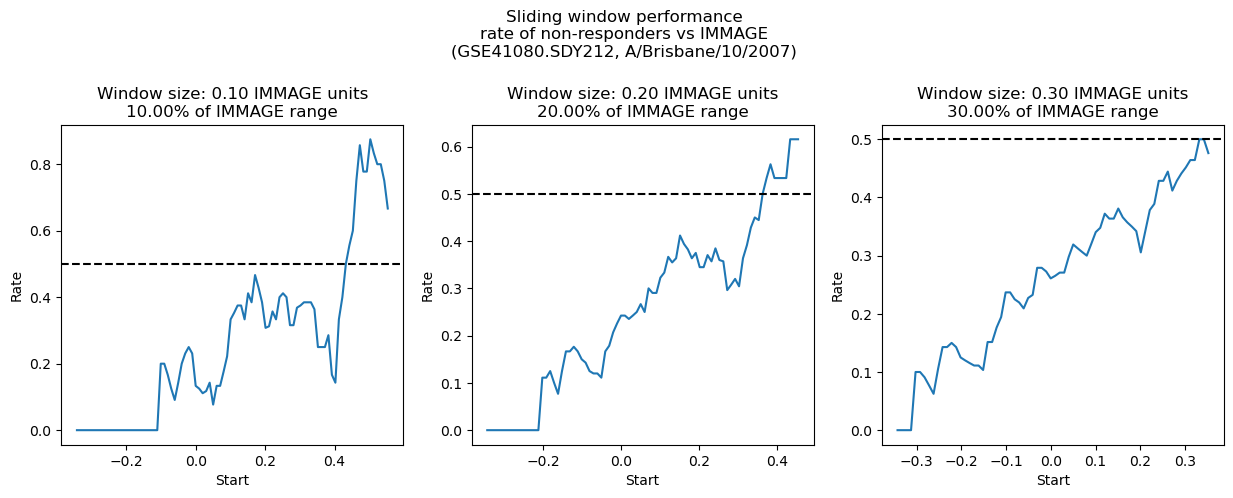

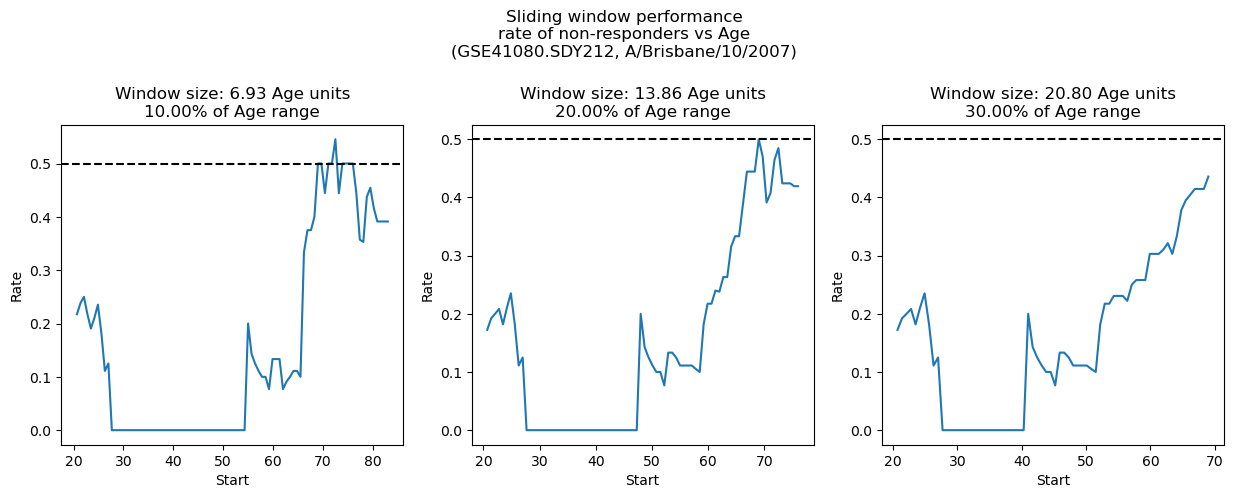

In [34]:
def generate_windows_and_rates(data, feature_col, num_units, num_units_per_window):
    window_starts = np.linspace(start=data[feature_col].min(), stop=data[feature_col].max(), num=num_units)
    window_size = (data[feature_col].max() - data[feature_col].min()) / num_units * num_units_per_window
    windows = pd.DataFrame({"start": window_starts[:-num_units_per_window], "end": window_starts[num_units_per_window:]})
    rates = []

    for i, start, end in windows.itertuples():
        over = data[feature_col] >= windows["start"][i]
        under = data[feature_col] < windows["end"][i]
        rates.append(data.loc[(over & under), "y"].mean())

    rates = pd.Series(rates).fillna(0)
    windows["rate"] = rates
    threshold_idx = rates.argmax()

    return windows, window_size

def plot_sliding_window(feature_col):
   # Create subplots
   num_units = 100
   fig, axs = plt.subplots(1, 3, figsize=(15, 5))

   # Iterate over different values of num_units_per_window
   for i, num_units_per_window in enumerate([10, 20, 30]):
      windows, window_size = generate_windows_and_rates(data, feature_col, num_units, num_units_per_window)
      sns.lineplot(data=windows, x="start", y="rate", ax=axs[i])
      axs[i].axhline(y=0.5, color='black', linestyle='--')
      axs[i].set_title(f'Window size: {window_size:.2f} {feature_col} units\n{num_units_per_window/num_units*100:.2f}% of {feature_col} range')
      axs[i].set_xlabel('Start')
      axs[i].set_ylabel('Rate')

   # Add a common title
   fig.suptitle(f'Sliding window performance\nrate of non-responders vs {feature_col}\n({dataset_name}, {strain})')
   plt.subplots_adjust(top=0.75)

   plt.show()

plot_sliding_window(immage_col)
plot_sliding_window(age_col)